# Final Project Stock Tracking of Congress members: David Katilius

*Please note that when running both of my API's to not request too many times too quickly, and that if an error comes up its likely because there is a limit of to the total number of requests. I believe this is like 50-100 requests for both, and I definitly did less than that here, but you could easily go over.*

In [1]:
# hereis a general imports run to get everything
import requests 
import pandas as pd
import numpy as np
import seaborn as sb
AlphaAPIKey = "XZV2W37061QL1374"
FinnAPIKey = "clr7bl9r01qou4llrq00clr7bl9r01qou4llrq0g"

# I'd like to note that I didn't do a lot of if statements to get rid of errors in my function
# In the future I can easily implement something but for now I just wanted to start collecting data


In [2]:
# overall project plan:
# start with total number of transactions
# pick top transactions
# then look to see whether more buys than sells (say this gives us no info)
# then look at the most recent call by people
# look at stock price average for the next 3-6 months
# see if it goes down
# for 3rd source, looking at lobbying expenses and seeing if the companies that are traded the most spend a lot
# maybe this has some sort of correlation between one another?


#side notes:
# put in a LOT OF COMMENTS for how code works


# make a story in order

# explain what information you are getting from tables or visualizations and why you put it in!



In [3]:
#step one is to first open up my Congress Transaction documents (this is an EXCEL file):
CongressDF = pd.read_csv("all_transactions.csv")
CongressDF.head(5)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
0,2021,10/4/2021,9/27/2021,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Integrated oil Companies,Energy,Republican
1,2021,10/4/2021,9/13/2021,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Integrated oil Companies,Energy,Republican
2,2021,10/4/2021,9/10/2021,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Real Estate Investment Trusts,Real Estate,Republican
3,2021,10/4/2021,9/28/2021,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,NC,https://disclosures-clerk.house.gov/public_dis...,False,Farming/Seeds/Milling,Consumer Non-Durables,Republican
4,2021,10/4/2021,9/17/2021,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,CA,https://disclosures-clerk.house.gov/public_dis...,False,Investment Bankers/Brokers/Service,Finance,Democrat


In [4]:
# let's take a look at which stocks have the highest usage rates (aka what are they buying and selling the most)
# lets do a crosstab and a stacked bar chart of the ticker (name of the stock) and whether they are buying or selling
#(type)
MostStocks = pd.crosstab(CongressDF["ticker"],CongressDF["type"])

# Now I need a total tab of all the transactions
MostStocks["Total"] = MostStocks["exchange"]+MostStocks["purchase"]+MostStocks["sale"]+MostStocks["sale_full"]
+MostStocks["sale_partial"]

#finally we need to sort that table by the totals so we can see which stocks have the highest usage rates
MostStocks = MostStocks.sort_values("Total",ascending=False)

# now print the top 6 (as number one you'll will see isn't a stock)
MostStocks.head(6)

# as we can see there is a ticker -- that has the most amount, but that isn't a company?
# to explain it is quite simply when they purchase debt, or sell one from there trust funds. It's a bit confusing
# but it has to do with state laws and transactions of debts. Not something that is valuable to us

type,exchange,purchase,sale,sale_full,sale_partial,Total
ticker,,,,,,
--,32,868,0,481,94,1381
MSFT,0,155,0,104,40,259
NTAP,0,87,0,76,1,163
AAPL,1,89,0,55,53,145
TDDXX,0,44,0,78,0,122
AMZN,0,68,0,36,12,104


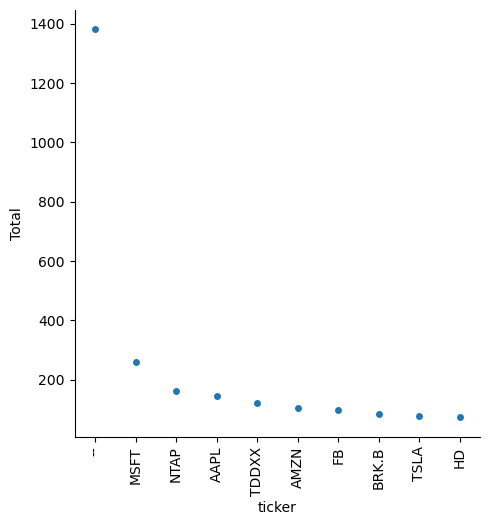

In [5]:
# now we can do a catplot to see graphical what the total number of usage rates are happening
sb.catplot(data=MostStocks.head(10),x='ticker',y="Total").set_xticklabels(rotation=90)
# however since -- is a really large number in the next graphic we will avoid it because again it isn't a stock

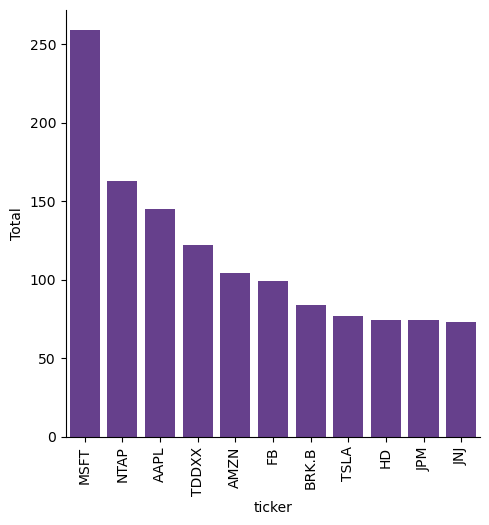

In [6]:
# since I am mainly interested in the top stocks that are being traded frequently I set the index to skip the -- and 
# get the next 11 
# to do this I reset the index so that it starts from 1 and then I used loc to find the top 11.
sb.catplot(data=MostStocks.reset_index().loc[1:11],x='ticker',y="Total",kind="bar",
           color="RebeccaPurple").set_xticklabels(rotation=90)

In [7]:
# in this function I will be able to analyze more specifically what types of transactions are made by each company
# along with the most recent ones.
def FindCongressInfoOnStock(StockTicker):
    import requests 
    import pandas as pd
    import numpy as np
    import seaborn as sb
    #Open dataset
    CongressDF = pd.read_csv("all_transactions.csv")
    #this changing time to make it readable in pandas
    CongressDF["transaction_date"] = pd.to_datetime(CongressDF["transaction_date"],format="%m/%d/%Y")
    #print(CongressDF)
    
    # now we make the pull the ticker's specific data using a boolean mask
    TickerDF = CongressDF[CongressDF["ticker"] == StockTicker]
    # then we make a histplot of the types(aka if they purchase or sell)
    # as you will see most of them are about even number of purchases and sells, and it doesn't tell us
    # when they bought or sold, so this may not be the most helpful information.
    sb.histplot(TickerDF["type"])
    
    # so let's sort the transaction dates to see when they actually bought or sold
    TickerDF = TickerDF.sort_values("transaction_date",ascending=False).reset_index()
    
    # lets return the most recent ones and see whether the stock has gone up or down in the past few months
    print("The most recent transaction date is " +str(TickerDF["transaction_date"][0])+ " where it was a "
          +TickerDF["type"][0]+" of the stock")
    return(TickerDF.head(3))
    

The most recent transaction date is 2023-04-14 00:00:00 where it was a purchase of the stock


,index,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
0,3057,2023,4/26/2023,2023-04-14,self,NTAP,NetApp Inc - Stock,purchase,"$1,001 - $15,000",Doug Lamborn,CO05,CO,https://disclosures-clerk.house.gov/public_dis...,False,Electronic Components,Technology,Republican
1,3056,2023,4/26/2023,2023-04-14,self,NTAP,NetApp Inc - Stock,purchase,"$1,001 - $15,000",Doug Lamborn,CO05,CO,https://disclosures-clerk.house.gov/public_dis...,False,Electronic Components,Technology,Republican
2,10756,2022,12/6/2022,2022-11-18,NaN,NTAP,NetApp Inc Stock,purchase,"$1,001 - $15,000",Doug Lamborn,CO05,CO,https://disclosures-clerk.house.gov/public_dis...,False,Electronic Components,Technology,Republican


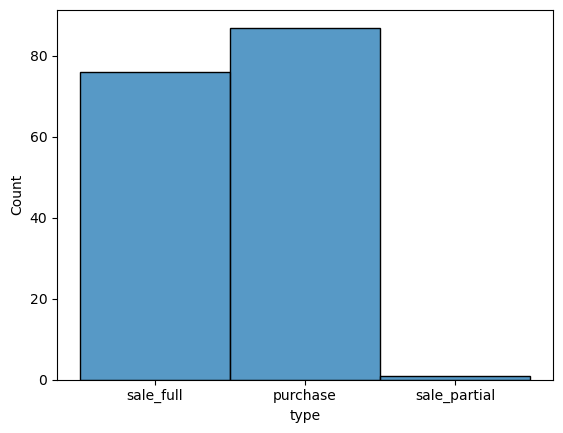

In [8]:
FindCongressInfoOnStock("NTAP")

The most recent transaction date is 2023-03-17 00:00:00 where it was a purchase of the stock


,index,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
0,6985,2023,4/6/2023,2023-03-17,self,AAPL,Apple Inc - Excercise 100 call options purchas...,purchase,"$500,001 - $1,000,000",Nancy Pelosi,CA11,CA,https://disclosures-clerk.house.gov/public_dis...,False,Computer Manufacturing,Technology,Democrat
1,118,2023,4/20/2023,2023-03-06,joint,AAPL,Apple Inc,sale_partial,"$1,001 - $15,000",Josh Gottheimer,NJ05,NJ,https://disclosures-clerk.house.gov/public_dis...,False,Computer Manufacturing,Technology,Democrat
2,11363,2023,2/17/2023,2023-01-27,joint,AAPL,Apple Inc,sale_partial,"$1,001 - $15,000",Josh Gottheimer,NJ05,NJ,https://disclosures-clerk.house.gov/public_dis...,False,Computer Manufacturing,Technology,Democrat


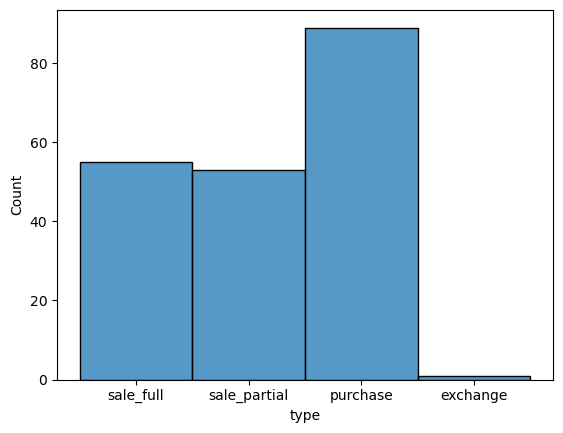

In [9]:
FindCongressInfoOnStock("AAPL")

The most recent transaction date is 2023-04-10 00:00:00 where it was a sale_full of the stock


,index,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
0,4882,2023,4/14/2023,2023-04-10,self,MSFT,Microsoft Corporation,sale_full,"$15,001 - $50,000",Michael C. Burgess,TX26,TX,https://disclosures-clerk.house.gov/public_dis...,False,Computer Software: Prepackaged Software,Technology,Republican
1,15616,2023,5/2/2023,2023-04-10,NaN,MSFT,Microsoft Corp,sale_full,"$1,001 - $15,000",Ada Norah Henriquez,PR00,PR,https://disclosures-clerk.house.gov/public_dis...,False,Computer Software: Prepackaged Software,Technology,NaN
2,137,2023,4/20/2023,2023-03-31,joint,MSFT,Microsoft Corporation,purchase,"$1,001 - $15,000",Josh Gottheimer,NJ05,NJ,https://disclosures-clerk.house.gov/public_dis...,False,Computer Software: Prepackaged Software,Technology,Democrat


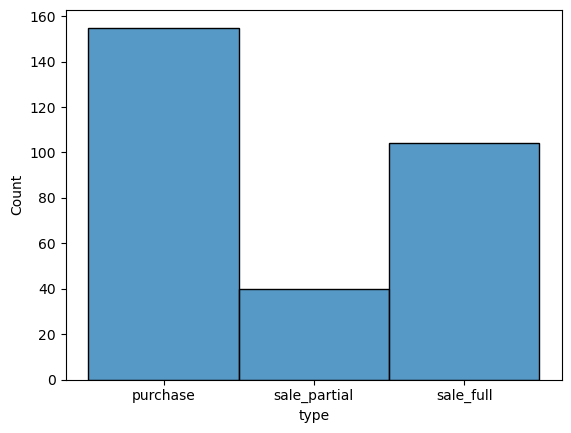

In [10]:
FindCongressInfoOnStock("MSFT")

In [11]:
# this line of code is just to experiement with AlphaAdvantage so I can see what their JSON looks like
# feel free to ignore if you so desire.
StockPrice = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol=IBM&apikey=XZV2W37061QL1374").json()
print(StockPrice["Weekly Time Series"]['2023-04-14'])

{'1. open': '129.8300', '2. high': '131.1050', '3. low': '126.0000', '4. close': '128.1400', '5. volume': '19506500'}


In [12]:
# now I want to see how the stock trended after that specific date was mentioned
# does the stock trend up when it was purchased, or does it trend down
# vise versa with sale.
def getStockTrend(ticker,endDate):
    # set up things to get it working
    import requests 
    import pandas as pd
    import numpy as np
    import seaborn as sb
    APIKey = "XZV2W37061QL1374"    
    
    #pull out the right stock ticker data:
    StockPrice = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol="
                              +ticker+"&apikey="+APIKey).json()
    #make 2 list to store the high values in the stock each week up until the endDate
    AllCloseValues =[]
    
    FinalCloseList = []
    WeeksList = []
    
    # one key thing I need is how many weeks occured between today and the date the the trade was made
    # to do this I took information from two different sources:
    #https://stackoverflow.com/questions/14191832/how-to-calculate-difference-between-two-dates-in-weeks-in-python
    #and
    # https://www.programiz.com/python-programming/datetime/current-datetime
    
    # It was quite easy to understand how datetime works in python doing these two things
    from datetime import date
    
    #first I need to get todays date:
    today = date.today()
    
    # now I use the input from end date and change it into something readable by datetime:
    # I have to check it is in the correct format first using the dashes
    if("-" not in endDate):
        print("Please use the YYYY-MM-DD format please!")
    else:
        #if it is in the correct format then using date function I have to split the end date into its respective
        # year, month, and day
        Decisiondate = date(int(endDate.split("-")[0]), int(endDate.split("-")[1]), int(endDate.split("-")[2]))
        
        #then to get the final result I have to subtract todays date to the desired date and divde by 7 to get the
        # number of weeks in between both dates
        result = (today-Decisiondate).days//7
        print("There are "+str(result)+" weeks in between today and the mentioned end date.")
        #awesome now I have the total number of weeks between today's date and the desired close date!
        
        # so now I need to go through my requests system and get the list of all weekly stock closing prices

        # iterate through all the keys which start at this current week and go back all the way to 2019!
        for key in StockPrice['Weekly Time Series']:
            # this next line stores all those data points of the closing stock price from today back to 2019
            AllCloseValues.append(StockPrice['Weekly Time Series'][key]["4. close"])
               
        #since I only want that number of weeks from today to back when the end date is set we will iterate through
        # and append one list onto another.
        # I also will make a week list counter, just to make graphing easier during extraction!
        for i in range(0, result):
            WeeksList.append(i)
            FinalCloseList.append(AllCloseValues[i])
        
        #convert that final list into a data frame
        FinalDF = pd.DataFrame(FinalCloseList,columns=["close_values"])
        # now I just need to insert the inverse total number of weeks 
        #(as it starts from today and goes backward normally)
        FinalDF["Weeks"] = WeeksList[::-1]
        return(FinalDF)

In [13]:
AAPLDF = getStockTrend("AAPL","2023-03-17")
AAPLDF

There are 38 weeks in between today and the mentioned end date.


,close_values,Weeks
0,193.1800,37
1,195.7100,36
2,191.2400,35
3,189.9700,34
4,189.6900,33
5,186.4000,32
6,176.6500,31
7,168.2200,30
8,172.8800,29
9,178.8500,28


In [14]:
# Apprently it read the Close values as a string instead of a float, so we need to change that for all 3 
# (don't worry I fix this in the last function, I just wanted to show off that I know lambda functions and how to 
# use apply) 
AAPLDF["close_values"]=AAPLDF["close_values"].apply(lambda x: float(x))

# According to Dr Zietz this is how we are supposed to do the line above, but I don't think we ever learned it in class
# AAPLDF["close_values"] = AAPLDF["close_values"].astype(float)

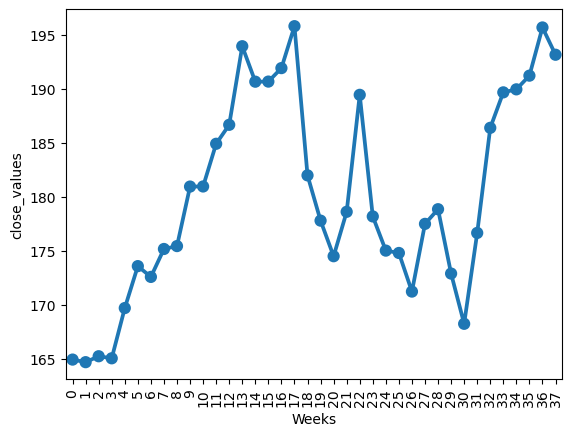

In [15]:
# note on this plot that the weeks are from when the either the sale or purchase started, to today
# meaning that there has been 37 weeks between today and the last time this stock was mentioned in the 
# congress excel file
sb.pointplot(data=AAPLDF,y="close_values",x="Weeks").tick_params(axis='x', rotation=90)

In [16]:
MSFTDF = getStockTrend("MSFT","2023-04-10")

There are 35 weeks in between today and the mentioned end date.


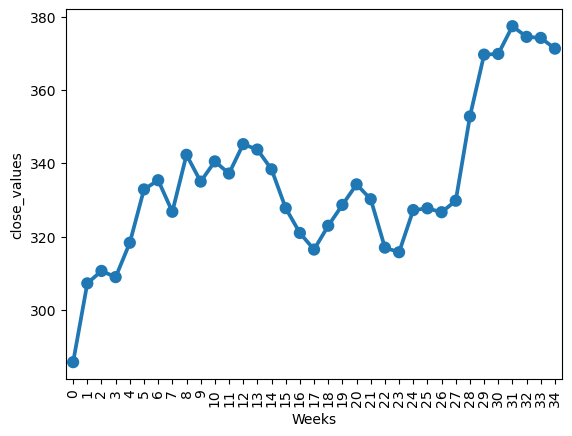

In [17]:
NewMSFTDF = MSFTDF
#do the same thing as apple
NewMSFTDF["close_values"] = NewMSFTDF["close_values"].apply(lambda x: float(x))
sb.pointplot(data=NewMSFTDF,x="Weeks",y="close_values").tick_params(axis='x', rotation=90)

In [18]:
NTAPDF = getStockTrend("NTAP","2023-04-14")

There are 34 weeks in between today and the mentioned end date.


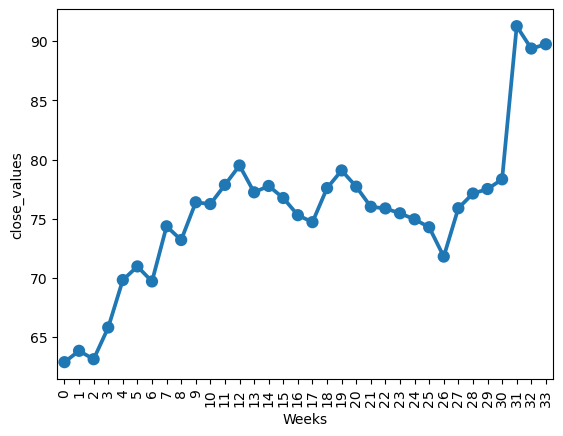

In [19]:
# finally once more with NTAP
NTAPDF["close_values"]=NTAPDF["close_values"].apply(lambda x: float(x))
sb.pointplot(data=NTAPDF,y="close_values",x="Weeks").tick_params(axis='x', rotation=90)

In [22]:
# here in this function I will add up all the income from lobbying data from 2022

def totalRecentLobbyingExpenses(ticker):
    import requests 
    import pandas as pd
    import numpy as np
    import seaborn as sb
    
    FinnAPIKey = "clr7bl9r01qou4llrq00clr7bl9r01qou4llrq0g"
    
    # now we need to request the 2022 data as unfortunately it isn't updated for 2023 yet
    FinnRequests = requests.get("https://finnhub.io/api/v1/stock/lobbying?symbol="
                                +ticker+"&from=2022-01-01&to=2022-12-31&token="+FinnAPIKey).json()
    
   # Now let's add up all of the income that the lobbying firms received during 2022
    # and we will compare that to the amount of sales/puchases a stock received during that year
    IncomeCount = 0
    
    # first get through the data tab then iterate through the list of all the data
    for item in FinnRequests["data"]:
        # check to see if the income made by the lobby isn't zero to help sum up
        if(item["income"] != None):
            IncomeCount = IncomeCount + item["income"]
        
        # print out the total sum using the fancy formatting that we did with strings
    print("The total lobbying income from the year 2022 is: {0:,} ".format(IncomeCount))
    
    # now let's also compare that to see if perhaps there have been a lot more purchases that year
    
    #open up that congress excel file again
    CongressDF = pd.read_csv("all_transactions.csv")
    #this changing time to make it readable in pandas
    CongressDF["transaction_date"] = pd.to_datetime(CongressDF["transaction_date"],format="%m/%d/%Y")
    
    # now we need to find transaction dates within 2022
    # apparently query isn't working for something like this so I will just do 3 boolean masks,
    CongressDF = CongressDF[CongressDF["transaction_date"] <= "2022-12-31"]
    CongressDF = CongressDF[CongressDF["transaction_date"] >= "2022-01-01"]
    TickerDF = CongressDF[CongressDF["ticker"] == ticker]
    
    
    # then we make a histplot of the types(aka if they purchase or sell)
    # this will tell us if typically stocks with greater lobbying income get bought more
    
    sb.histplot(TickerDF["type"])
    # I'll also print a few lines of the ticker trades just for fun!
    #print(TickerDF.head(5))

    
    # if you want to just look at the total sales vs purchases, and not look at whether it was partial or not
    # then feel free to uncomment both of these lines and Comment the one above.
    #TickerDF["NewType"] = TickerDF["type"].apply(lambda x: x.split('_')[0])
    #sb.histplot(TickerDF["NewType"])


The total lobbying income from the year 2022 is: 2,260,000 


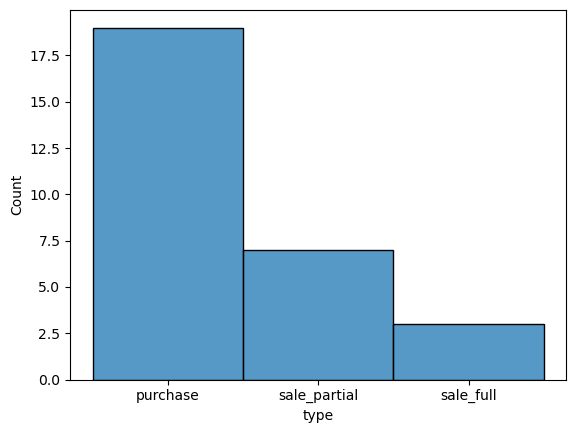

In [23]:
totalRecentLobbyingExpenses("AAPL")

The total lobbying income from the year 2022 is: 3,910,000 


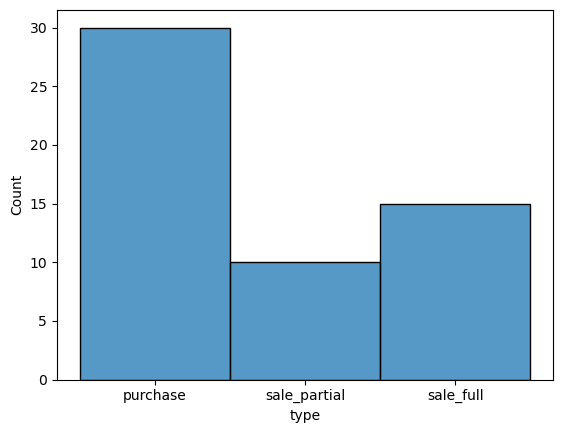

In [24]:
totalRecentLobbyingExpenses("MSFT")

The total lobbying income from the year 2022 is: 23,000 


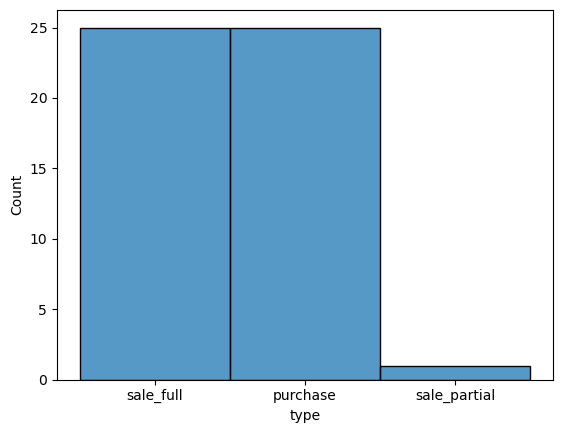

In [25]:
totalRecentLobbyingExpenses("NTAP")

The total lobbying income from the year 2022 is: 490,000 


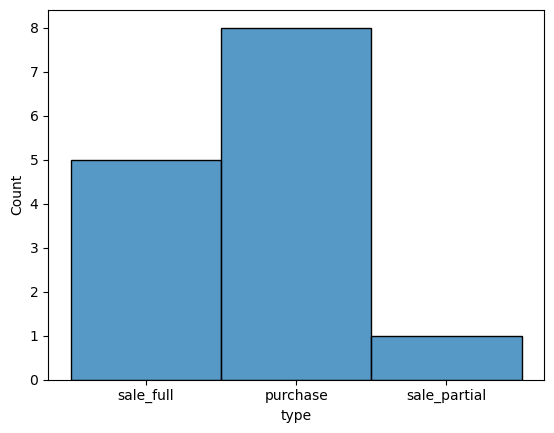

In [26]:
# here I just wanted to show that the trend was the same for other companies.
totalRecentLobbyingExpenses("XOM")

The total lobbying income from the year 2022 is: 150,000 


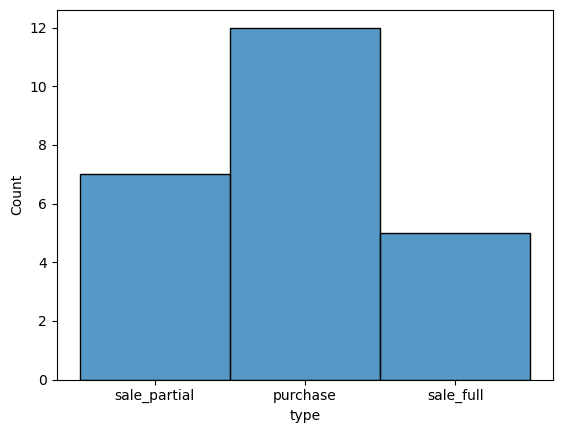

In [27]:
totalRecentLobbyingExpenses("TSLA")

In [29]:
# now for this final function itwill get the stocks monthly trend during 2022 for the requested ticker
def get2022StockTrend(ticker):
    # set up things to get it working
    import requests 
    import pandas as pd
    import numpy as np
    import seaborn as sb
    APIKey = "XZV2W37061QL1374"    
    
    
    #pull out the right stock ticker data:
    StockPrice = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol="
                              +ticker+"&apikey="+APIKey).json()
    #make 2 list to store the close values in the stock each month along with the date 
    AllCloseValues =[]
    DateList = []

    # so now I need to go through my requests system and get the list of all weekly stock closing prices

    # iterate through all the keys and find to make sure that the month value is in 2022.
    for key in StockPrice['Monthly Time Series']:
        # I need to check to make sure that the key is in 2022
        if("2022" in key):
            # if it is store the value in a list
            AllCloseValues.append(float(StockPrice['Monthly Time Series'][key]["4. close"]))
            # and store the date into another list
            DateList.append(key)
    
    
    #print(AllCloseValues)
    #print(DateList)

    # now I store the Values into a dataframe to make graphing easier
    FinalDF = pd.DataFrame(AllCloseValues,columns=["Close values"])
    # now I justneed to insert the dates that these values occurred
    FinalDF["Dates"] = DateList
    return(FinalDF)

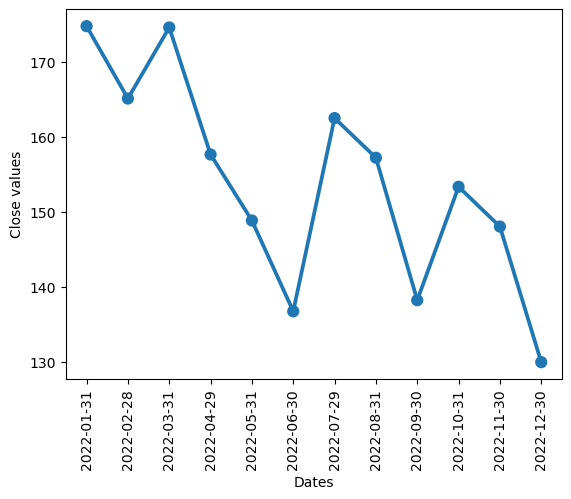

In [30]:
# here we will get the graph of the stock trend of apple during 2022
# note that we use the inverse in the data set as other wise the graph will start from december of 2022 and go back to 
# january of the year
YearAAPL = get2022StockTrend("AAPL")
sb.pointplot(data=YearAAPL[::-1],y="Close values",x="Dates").tick_params(axis='x', rotation=90)

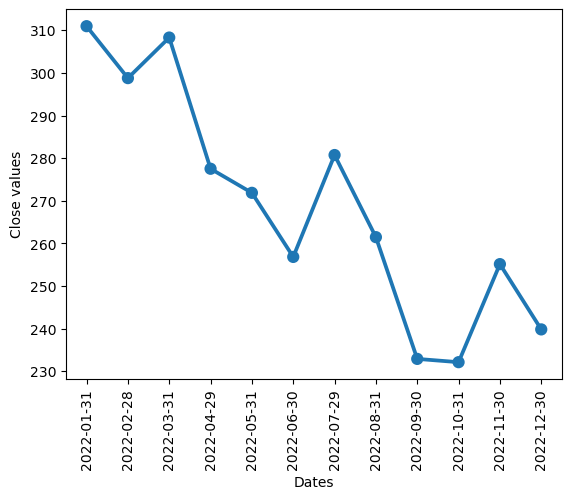

In [31]:
YearMSFT = get2022StockTrend("MSFT")
# here we will plot the stock price throughout the whole year of 2022 and see what happens to it 
# note we have to invert the data set as naturally it starts at the date closest to today and goes backwards
sb.pointplot(data=YearMSFT[::-1],y="Close values",x="Dates").tick_params(axis='x', rotation=90)

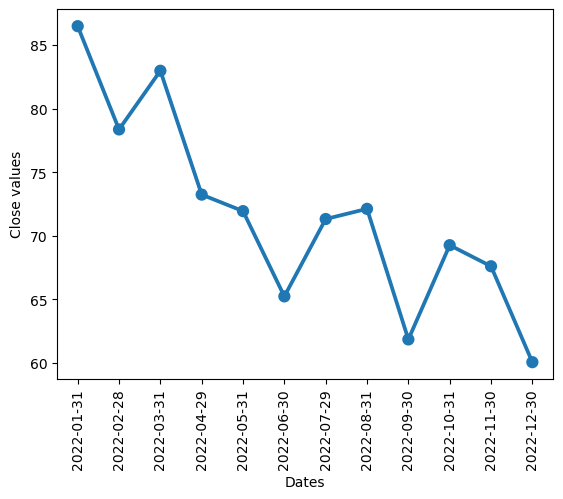

In [32]:
YearNTAP = get2022StockTrend("NTAP")
sb.pointplot(data=YearNTAP[::-1],y="Close values",x="Dates").tick_params(axis='x', rotation=90)

In [33]:
# these next line of code checks to see if any of congress decided to purchase the stock during June of 2022
CongressDF = pd.read_csv("all_transactions.csv")
CongressDF["transaction_date"] = pd.to_datetime(CongressDF["transaction_date"],format="%m/%d/%Y")
# simply do similar things that we did in the function above to find the correct transaction dates
# and to find top 10 (there are only 3).
CongressDF = CongressDF[CongressDF["transaction_date"] <= "2022-08-01"]
CongressDF = CongressDF[CongressDF["transaction_date"] >= "2022-06-01"]
TickerDF = CongressDF[CongressDF["ticker"] == "AAPL"]
TickerDF.head(10)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
7866,2022,7/22/2022,2022-06-14,joint,AAPL,Apple Inc,sale_partial,"$1,001 - $15,000",Josh Gottheimer,NJ05,NJ,https://disclosures-clerk.house.gov/public_dis...,False,Computer Manufacturing,Technology,Democrat
11835,2022,7/14/2022,2022-06-17,self,AAPL,Apple Inc - 50 CALL options @ $100 expiry 06/1...,sale_partial,"$100,001 - $250,000",Nancy Pelosi,CA12,CA,https://disclosures-clerk.house.gov/public_dis...,False,Computer Manufacturing,Technology,Democrat
14890,2022,8/29/2022,2022-07-15,NaN,AAPL,Apple Inc,purchase,"$1,001 - $15,000",Josh Gottheimer,NJ05,NJ,https://disclosures-clerk.house.gov/public_dis...,False,Computer Manufacturing,Technology,Democrat


In [ ]:
# thanks for going through the entire program! 
# further on I'd like to try and get actually percentages for individual people between when they bought and sold a
# stock. I'd also like to add ways to prevent errors and mis inputs that people could put in.